In [1]:
#| default_exp models.autoformer

# Autoformer

The Autoformer model tackles the challenge of finding reliable dependencies on intricate temporal patterns of long-horizon forecasting.

The architecture has the following distinctive features:
- In-built progressive decomposition in trend and seasonal compontents based on a moving average filter.
- Auto-Correlation mechanism that discovers the period-based dependencies by
calculating the autocorrelation and aggregating similar sub-series based on the periodicity.
- Classic encoder-decoder proposed by Vaswani et al. (2017) with a multi-head attention mechanism.

The Autoformer model utilizes a three-component approach to define its embedding:
- It employs encoded autoregressive features obtained from a convolution network.
- Absolute positional embeddings obtained from calendar features are utilized.

**References**<br>
- [Wu, Haixu, Jiehui Xu, Jianmin Wang, and Mingsheng Long. "Autoformer: Decomposition transformers with auto-correlation for long-term series forecasting"](https://proceedings.neurips.cc/paper/2021/hash/bcc0d400288793e8bdcd7c19a8ac0c2b-Abstract.html)<br>

![Figure 1. Autoformer Architecture.](imgs_models/autoformer.png)

In [20]:
#| export
import math
import numpy as np
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.common._modules import DataEmbedding
from neuralforecast.common._base_windows import BaseWindows

from neuralforecast.losses.pytorch import MAE

In [21]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

## 1. Auxiliary Functions

In [22]:
#| export
class AutoCorrelation(nn.Module):
    """
    AutoCorrelation Mechanism with the following two phases:
    (1) period-based dependencies discovery
    (2) time delay aggregation
    This block can replace the self-attention family mechanism seamlessly.
    """
    def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def time_delay_agg_training(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the training phase.
        """
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
        weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values
        delays_agg = torch.zeros_like(values, dtype=torch.float, device=values.device)
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(index[i]), -1)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_inference(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the inference phase.
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length, device=values.device).unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(batch, head, channel, 1)
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        weights = torch.topk(mean_value, top_k, dim=-1)[0]
        delay = torch.topk(mean_value, top_k, dim=-1)[1]
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values, dtype=torch.float, device=values.device)
        for i in range(top_k):
            tmp_delay = init_index + delay[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_full(self, values, corr):
        """
        Standard version of Autocorrelation
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length, device=values.device).unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(batch, head, channel, 1)
        # find top k
        top_k = int(self.factor * math.log(length))
        weights = torch.topk(corr, top_k, dim=-1)[0]
        delay = torch.topk(corr, top_k, dim=-1)[1]
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values, dtype=torch.float, device=values.device)
        for i in range(top_k):
            tmp_delay = init_index + delay[..., i].unsqueeze(-1)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * (tmp_corr[..., i].unsqueeze(-1))
        return delays_agg

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :], dtype=torch.float, device=queries.device)
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values = values[:, :L, :, :]
            keys = keys[:, :L, :, :]

        # period-based dependencies
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)

        # time delay agg
        if self.training:
            V = self.time_delay_agg_training(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)
        else:
            V = self.time_delay_agg_inference(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)

        if self.output_attention:
            return (V.contiguous(), corr.permute(0, 3, 1, 2))
        else:
            return (V.contiguous(), None)


class AutoCorrelationLayer(nn.Module):
    def __init__(self, correlation, hidden_size, n_head, d_keys=None,
                 d_values=None):
        super(AutoCorrelationLayer, self).__init__()

        d_keys = d_keys or (hidden_size // n_head)
        d_values = d_values or (hidden_size // n_head)

        self.inner_correlation = correlation
        self.query_projection = nn.Linear(hidden_size, d_keys * n_head)
        self.key_projection = nn.Linear(hidden_size, d_keys * n_head)
        self.value_projection = nn.Linear(hidden_size, d_values * n_head)
        self.out_projection = nn.Linear(d_values * n_head, hidden_size)
        self.n_head = n_head

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_head

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_correlation(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    

class LayerNorm(nn.Module):
    """
    Special designed layernorm for the seasonal part
    """
    def __init__(self, channels):
        super(LayerNorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels)

    def forward(self, x):
        x_hat = self.layernorm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias


class MovingAvg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(MovingAvg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class SeriesDecomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(SeriesDecomp, self).__init__()
        self.MovingAvg = MovingAvg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.MovingAvg(x)
        res = x - moving_mean
        return res, moving_mean


class EncoderLayer(nn.Module):
    """
    Autoformer encoder layer with the progressive decomposition architecture
    """
    def __init__(self, attention, hidden_size, conv_hidden_size=None, MovingAvg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        conv_hidden_size = conv_hidden_size or 4 * hidden_size
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=conv_hidden_size, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=conv_hidden_size, out_channels=hidden_size, kernel_size=1, bias=False)
        self.decomp1 = SeriesDecomp(MovingAvg)
        self.decomp2 = SeriesDecomp(MovingAvg)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn


class Encoder(nn.Module):
    """
    Autoformer encoder
    """
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):
    """
    Autoformer decoder layer with the progressive decomposition architecture
    """
    def __init__(self, self_attention, cross_attention, hidden_size, c_out, conv_hidden_size=None,
                 MovingAvg=25, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        conv_hidden_size = conv_hidden_size or 4 * hidden_size
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=conv_hidden_size, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=conv_hidden_size, out_channels=hidden_size, kernel_size=1, bias=False)
        self.decomp1 = SeriesDecomp(MovingAvg)
        self.decomp2 = SeriesDecomp(MovingAvg)
        self.decomp3 = SeriesDecomp(MovingAvg)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(in_channels=hidden_size, out_channels=c_out, kernel_size=3, stride=1, padding=1,
                                    padding_mode='circular', bias=False)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x, trend1 = self.decomp1(x)
        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])
        x, trend2 = self.decomp2(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        x, trend3 = self.decomp3(x + y)

        residual_trend = trend1 + trend2 + trend3
        residual_trend = self.projection(residual_trend.permute(0, 2, 1)).transpose(1, 2)
        return x, residual_trend


class Decoder(nn.Module):
    """
    Autoformer decoder
    """
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, trend=None):
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)
            trend = trend + residual_trend

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x, trend

## 2. Autoformer

In [23]:
#| export
class Autoformer(BaseWindows):
    """ Autoformer

    The Autoformer model tackles the challenge of finding reliable dependencies on intricate temporal patterns of long-horizon forecasting.

    The architecture has the following distinctive features:
    - In-built progressive decomposition in trend and seasonal compontents based on a moving average filter.
    - Auto-Correlation mechanism that discovers the period-based dependencies by
    calculating the autocorrelation and aggregating similar sub-series based on the periodicity.
    - Classic encoder-decoder proposed by Vaswani et al. (2017) with a multi-head attention mechanism.

    The Autoformer model utilizes a three-component approach to define its embedding:
    - It employs encoded autoregressive features obtained from a convolution network.
    - Absolute positional embeddings obtained from calendar features are utilized.

    *Parameters:*<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
	`decoder_input_size_multiplier`: float = 0.5, .<br>
    `hidden_size`: int=128, units of embeddings and encoders.<br>
    `n_head`: int=4, controls number of multi-head's attention.<br>
    `dropout`: float (0, 1), dropout throughout Autoformer architecture.<br>
	`factor`: int=3, Probsparse attention factor.<br>
	`conv_hidden_size`: int=32, channels of the convolutional encoder.<br>
	`activation`: str=`GELU`, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid', 'GELU'].<br>
    `encoder_layers`: int=2, number of layers for the TCN encoder.<br>
    `decoder_layers`: int=1, number of layers for the MLP decoder.<br>
    `distil`: bool = True, wether the Autoformer decoder uses bottlenecks.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=1024, number of windows to sample in each inference batch.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

	*References*<br>
	- [Wu, Haixu, Jiehui Xu, Jianmin Wang, and Mingsheng Long. "Autoformer: Decomposition transformers with auto-correlation for long-term series forecasting"](https://proceedings.neurips.cc/paper/2021/hash/bcc0d400288793e8bdcd7c19a8ac0c2b-Abstract.html)<br>
    """
    # Class attributes
    SAMPLING_TYPE = 'windows'

    def __init__(self,
                 h: int, 
                 input_size: int,
                 stat_exog_list = None,
                 hist_exog_list = None,
                 futr_exog_list = None,
                 exclude_insample_y = False,
                 decoder_input_size_multiplier: float = 0.5,
                 hidden_size: int = 128, 
                 dropout: float = 0.05,
                 factor: int = 3,
                 n_head: int = 4,
                 conv_hidden_size: int = 32,
                 activation: str = 'gelu',
                 encoder_layers: int = 2, 
                 decoder_layers: int = 1,
                 MovingAvg_window: int = 25,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 5000,
                 learning_rate: float = 1e-4,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 **trainer_kwargs):
        super(Autoformer, self).__init__(h=h,
                                       input_size=input_size,
                                       hist_exog_list=hist_exog_list,
                                       stat_exog_list=stat_exog_list,
                                       futr_exog_list = futr_exog_list,
                                       exclude_insample_y = exclude_insample_y,
                                       loss=loss,
                                       valid_loss=valid_loss,
                                       max_steps=max_steps,
                                       learning_rate=learning_rate,
                                       num_lr_decays=num_lr_decays,
                                       early_stop_patience_steps=early_stop_patience_steps,
                                       val_check_steps=val_check_steps,
                                       batch_size=batch_size,
                                       windows_batch_size=windows_batch_size,
                                       valid_batch_size=valid_batch_size,
                                       inference_windows_batch_size=inference_windows_batch_size,
                                       start_padding_enabled = start_padding_enabled,
                                       step_size=step_size,
                                       scaler_type=scaler_type,
                                       num_workers_loader=num_workers_loader,
                                       drop_last_loader=drop_last_loader,
                                       random_seed=random_seed,
                                       **trainer_kwargs)

        # Architecture
        self.futr_input_size = len(self.futr_exog_list)
        self.hist_input_size = len(self.hist_exog_list)
        self.stat_input_size = len(self.stat_exog_list)

        if self.stat_input_size > 0:
            raise Exception('Autoformer does not support static variables yet')
        
        if self.hist_input_size > 0:
            raise Exception('Autoformer does not support historical variables yet')

        self.label_len = int(np.ceil(input_size * decoder_input_size_multiplier))
        if (self.label_len >= input_size) or (self.label_len <= 0):
            raise Exception(f'Check decoder_input_size_multiplier={decoder_input_size_multiplier}, range (0,1)')

        if activation not in ['relu', 'gelu']:
            raise Exception(f'Check activation={activation}')
        
        self.c_out = self.loss.outputsize_multiplier
        self.output_attention = False
        self.enc_in = 1 
        self.dec_in = 1

        # Decomposition
        self.decomp = SeriesDecomp(MovingAvg_window)

        # Embedding
        self.enc_embedding = DataEmbedding(c_in=self.enc_in,
                                           exog_input_size=self.hist_input_size,
                                           hidden_size=hidden_size, 
                                           pos_embedding=False,
                                           dropout=dropout)
        self.dec_embedding = DataEmbedding(self.dec_in,
                                           exog_input_size=self.hist_input_size,
                                           hidden_size=hidden_size, 
                                           pos_embedding=False,
                                           dropout=dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(False, factor,
                                      attention_dropout=dropout,
                                      output_attention=self.output_attention),
                        hidden_size, n_head),
                    hidden_size=hidden_size,
                    conv_hidden_size=conv_hidden_size,
                    MovingAvg=MovingAvg_window,
                    dropout=dropout,
                    activation=activation
                ) for l in range(encoder_layers)
            ],
            norm_layer=LayerNorm(hidden_size)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(True, factor, attention_dropout=dropout, output_attention=False),
                        hidden_size, n_head),
                    AutoCorrelationLayer(
                        AutoCorrelation(False, factor, attention_dropout=dropout, output_attention=False),
                        hidden_size, n_head),
                    hidden_size=hidden_size,
                    c_out=self.c_out,
                    conv_hidden_size=conv_hidden_size,
                    MovingAvg=MovingAvg_window,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(decoder_layers)
            ],
            norm_layer=LayerNorm(hidden_size),
            projection=nn.Linear(hidden_size, self.c_out, bias=True)
        )

    def forward(self, windows_batch):
        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        #insample_mask = windows_batch['insample_mask']
        #hist_exog     = windows_batch['hist_exog']
        #stat_exog     = windows_batch['stat_exog']
        futr_exog     = windows_batch['futr_exog']

        # Parse inputs
        insample_y = insample_y.unsqueeze(-1) # [Ws,L,1]
        if self.futr_input_size > 0:
            x_mark_enc = futr_exog[:,:self.input_size,:]
            x_mark_dec = futr_exog[:,-(self.label_len+self.h):,:]
        else:
            x_mark_enc = None
            x_mark_dec = None

        x_dec = torch.zeros(size=(len(insample_y),self.h,1)).to(insample_y.device)
        x_dec = torch.cat([insample_y[:,-self.label_len:,:], x_dec], dim=1)

        # decomp init
        mean = torch.mean(insample_y, dim=1).unsqueeze(1).repeat(1, self.h, 1)
        zeros = torch.zeros([x_dec.shape[0], self.h, x_dec.shape[2]], device=insample_y.device)
        seasonal_init, trend_init = self.decomp(insample_y)
        # decoder input
        trend_init = torch.cat([trend_init[:, -self.label_len:, :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.label_len:, :], zeros], dim=1)
        # enc
        enc_out = self.enc_embedding(insample_y, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        # dec
        dec_out = self.dec_embedding(seasonal_init, x_mark_dec)
        seasonal_part, trend_part = self.decoder(dec_out, enc_out, x_mask=None, cross_mask=None,
                                                 trend=trend_init)
        # final
        dec_out = trend_part + seasonal_part

        forecast = self.loss.domain_map(dec_out[:, -self.h:])
        return forecast

In [24]:
show_doc(Autoformer)

---

### Autoformer

>      Autoformer (h:int, input_size:int, stat_exog_list=None,
>                  hist_exog_list=None, futr_exog_list=None,
>                  exclude_insample_y=False,
>                  decoder_input_size_multiplier:float=0.5, hidden_size:int=128,
>                  dropout:float=0.05, factor:int=3, n_head:int=4,
>                  conv_hidden_size:int=32, activation:str='gelu',
>                  encoder_layers:int=2, decoder_layers:int=1,
>                  MovingAvg_window:int=25, loss=MAE(), valid_loss=None,
>                  max_steps:int=5000, learning_rate:float=0.0001,
>                  num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>                  val_check_steps:int=100, batch_size:int=32,
>                  valid_batch_size:Optional[int]=None, windows_batch_size=1024,
>                  inference_windows_batch_size=1024,
>                  start_padding_enabled=False, step_size:int=1,
>                  scaler_type:str='identity', random_seed:int=1,
>                  num_workers_loader:int=0, drop_last_loader:bool=False,
>                  **trainer_kwargs)

Autoformer

The Autoformer model tackles the challenge of finding reliable dependencies on intricate temporal patterns of long-horizon forecasting.

The architecture has the following distinctive features:
- In-built progressive decomposition in trend and seasonal compontents based on a moving average filter.
- Auto-Correlation mechanism that discovers the period-based dependencies by
calculating the autocorrelation and aggregating similar sub-series based on the periodicity.
- Classic encoder-decoder proposed by Vaswani et al. (2017) with a multi-head attention mechanism.

The Autoformer model utilizes a three-component approach to define its embedding:
- It employs encoded autoregressive features obtained from a convolution network.
- Absolute positional embeddings obtained from calendar features are utilized.

*Parameters:*<br>
`h`: int, forecast horizon.<br>
`input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `decoder_input_size_multiplier`: float = 0.5, .<br>
`hidden_size`: int=128, units of embeddings and encoders.<br>
`n_head`: int=4, controls number of multi-head's attention.<br>
`dropout`: float (0, 1), dropout throughout Autoformer architecture.<br>
    `factor`: int=3, Probsparse attention factor.<br>
    `conv_hidden_size`: int=32, channels of the convolutional encoder.<br>
    `activation`: str=`GELU`, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid', 'GELU'].<br>
`encoder_layers`: int=2, number of layers for the TCN encoder.<br>
`decoder_layers`: int=1, number of layers for the MLP decoder.<br>
`distil`: bool = True, wether the Autoformer decoder uses bottlenecks.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=1024, number of windows to sample in each inference batch.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

    *References*<br>
    - [Wu, Haixu, Jiehui Xu, Jianmin Wang, and Mingsheng Long. "Autoformer: Decomposition transformers with auto-correlation for long-term series forecasting"](https://proceedings.neurips.cc/paper/2021/hash/bcc0d400288793e8bdcd7c19a8ac0c2b-Abstract.html)<br>

In [6]:
show_doc(Autoformer.fit, name='Autoformer.fit')

---

### Autoformer.fit

>      Autoformer.fit (dataset, val_size=0, test_size=0, random_seed=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [8]:
show_doc(Autoformer.predict, name='Autoformer.predict')

---

### Autoformer.predict

>      Autoformer.predict (dataset, test_size=None, step_size=1,
>                          random_seed=None, **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

Seed set to 1
2023-11-02 00:51:42.424894: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 00:51:42.515256: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 00:51:42.837663: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 00:51:42.837728: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 00:51:42.839420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Atte

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

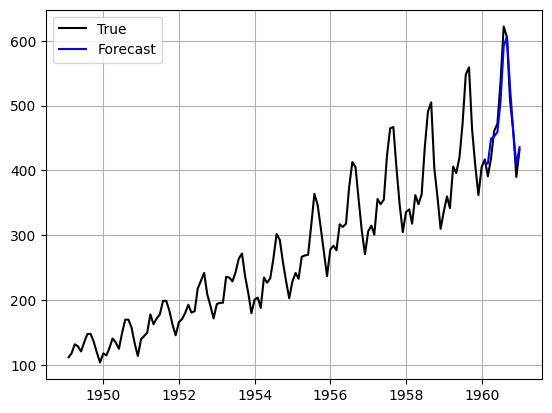

In [9]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = Autoformer(h=12,
                 input_size=24,
                 hidden_size = 16,
                 conv_hidden_size = 32,
                 n_head=2,
                 loss=MAE(),
                 futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=300,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = nf.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

if model.loss.is_distribution_output:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['Autoformer-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'][-12:], 
                    y1=plot_df['Autoformer-lo-90'][-12:].values, 
                    y2=plot_df['Autoformer-hi-90'][-12:].values,
                    alpha=0.4, label='level 90')
    plt.grid()
    plt.legend()
    plt.plot()
else:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['Autoformer'], c='blue', label='Forecast')
    plt.legend()
    plt.grid()

In [18]:
y_true = Y_test_df.y.values
y_hat = Y_hat_df['Autoformer'].values

from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  15.130399068196615
MSE:  349.1350725169759


# Autoformer Implementation

### Exchange rate

In [19]:
import pandas as pd
from neuralforecast import NeuralForecast

Y_df = pd.read_csv("raw_data/df_Exchange.csv")

Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
val_size = int(.1 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
7588,1,1990-01-01,-0.361671
7589,1,1990-01-02,-0.367639
15176,2,1990-01-01,0.735367
15177,2,1990-01-02,0.729629
22764,3,1990-01-01,-1.164373
22765,3,1990-01-02,-1.170907
30352,4,1990-01-01,2.851890
30353,4,1990-01-02,2.851890


In [25]:
horizon = 96

model = Autoformer(h=horizon,
                input_size = horizon,
                max_steps=100,
                val_check_steps=10,
                batch_size = 8,
                hidden_size = 32,
                windows_batch_size = 256,
                early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='D'
)

Y_hat_df = nf.cross_validation(df=Y_df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None)

Seed set to 1


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

In [27]:
Y_hat_df.head()

,unique_id,ds,cutoff,Autoformer,y
0,0,2006-08-16,2006-08-15,3.044964,2.948076
1,0,2006-08-17,2006-08-15,3.030476,3.049320
2,0,2006-08-18,2006-08-15,3.028900,3.064168
3,0,2006-08-19,2006-08-15,3.050043,3.005783
4,0,2006-08-20,2006-08-15,3.117382,3.010031


In [28]:
Y_hat_df.to_csv('results/Exchange_rate/autoformer.csv')

In [26]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(Y_hat_df['y'], Y_hat_df['Autoformer']))
print('MSE: ', mse(Y_hat_df['y'], Y_hat_df['Autoformer']))

MAE:  0.29645489153468074
MSE:  0.161861597390966


### Weather

In [11]:
import pandas as pd
from neuralforecast import NeuralForecast

Y_df = pd.read_csv("raw_data/df_Weather.csv")

Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
val_size = int(.1 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,H2OC (mmol/mol),2020-01-01 00:10:00,-0.999107
1,H2OC (mmol/mol),2020-01-01 00:20:00,-1.008072
52695,OT,2020-01-01 00:10:00,0.044395
52696,OT,2020-01-01 00:20:00,0.044134
105390,PAR (�mol/m�/s),2020-01-01 00:10:00,-0.679493
105391,PAR (�mol/m�/s),2020-01-01 00:20:00,-0.679493
158085,SWDR (W/m�),2020-01-01 00:10:00,-0.672767
158086,SWDR (W/m�),2020-01-01 00:20:00,-0.672767
210780,T (degC),2020-01-01 00:10:00,-1.459980
210781,T (degC),2020-01-01 00:20:00,-1.454798


In [8]:
horizon = 96

model = Autoformer(h=horizon,
                input_size = horizon,
                max_steps=100,
                val_check_steps=10,
                batch_size = 21,
                hidden_size = 16,
                windows_batch_size = 256,
                early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='10min'
)

Y_hat_df = nf.cross_validation(df=Y_df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None)

Seed set to 1
2023-11-02 05:44:45.812388: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 05:44:45.813943: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 05:44:45.836010: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 05:44:45.836041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 05:44:45.836057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Atte

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

In [10]:
Y_hat_df.to_csv('results/Weather/Autoformer.csv')

In [11]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(Y_hat_df['y'], Y_hat_df['Autoformer']))
print('MSE: ', mse(Y_hat_df['y'], Y_hat_df['Autoformer']))

MAE:  0.28974621539184015
MSE:  0.2305957080949505


### Ettm2

In [7]:
import pandas as pd
from neuralforecast import NeuralForecast

Y_df = pd.read_csv("raw_data/df_Ettm2.csv")

Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,HUFL,2016-07-01 00:00:00,-0.041413
1,HUFL,2016-07-01 00:15:00,-0.185467
57600,HULL,2016-07-01 00:00:00,0.040104
57601,HULL,2016-07-01 00:15:00,-0.214450
115200,LUFL,2016-07-01 00:00:00,0.695804
115201,LUFL,2016-07-01 00:15:00,0.434685
172800,LULL,2016-07-01 00:00:00,0.434430
172801,LULL,2016-07-01 00:15:00,0.428168
230400,MUFL,2016-07-01 00:00:00,-0.599211
230401,MUFL,2016-07-01 00:15:00,-0.658068


In [8]:
horizon = 96

model = Autoformer(h=horizon,
                input_size = horizon,
                max_steps=100,
                val_check_steps=10,
                batch_size = 7,
                   hidden_size = 16,
                windows_batch_size = 256,
                early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='15min'
)

Y_hat_df = nf.cross_validation(df=Y_df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None)

Seed set to 1
2023-11-02 06:05:55.346787: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 06:05:55.416697: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 06:05:55.854010: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 06:05:55.854073: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 06:05:55.856131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Atte

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

In [9]:
Y_hat_df.to_csv('results/Ettm2/Autoformer.csv')

In [11]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(Y_hat_df['y'], Y_hat_df['Autoformer']))
print('MSE: ', mse(Y_hat_df['y'], Y_hat_df['Autoformer']))

MAE:  0.3353140537163157
MSE:  0.2553693649575985


### ILI

In [12]:
import pandas as pd
from neuralforecast import NeuralForecast

Y_df = pd.read_csv("raw_data/df_ILI.csv")

Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
val_size = int(.1 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,% WEIGHTED ILI,2002-01-01,-0.421499
1,% WEIGHTED ILI,2002-01-08,-0.331239
966,%UNWEIGHTED ILI,2002-01-01,-0.472442
967,%UNWEIGHTED ILI,2002-01-08,-0.429154
1932,AGE 0-4,2002-01-01,-0.981641
1933,AGE 0-4,2002-01-08,-0.934213
2898,AGE 5-24,2002-01-01,-0.692621
2899,AGE 5-24,2002-01-08,-0.676837
3864,ILITOTAL,2002-01-01,-0.819695
3865,ILITOTAL,2002-01-08,-0.796703


In [16]:
horizon = 24

model = Autoformer(h=horizon,
                input_size = horizon,
                max_steps=100,
                val_check_steps=10,
                batch_size = 7,
                hidden_size = 16,
                windows_batch_size = 256,
                early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='W'
)

Y_hat_df = nf.cross_validation(df=Y_df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None)

Seed set to 1


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

In [17]:
Y_hat_df

,unique_id,ds,cutoff,Autoformer,y
0,% WEIGHTED ILI,2016-10-23,2016-10-16,0.751263,NaN
1,% WEIGHTED ILI,2016-10-30,2016-10-16,0.743696,NaN
2,% WEIGHTED ILI,2016-11-06,2016-10-16,0.570308,NaN
3,% WEIGHTED ILI,2016-11-13,2016-10-16,0.405683,NaN
4,% WEIGHTED ILI,2016-11-20,2016-10-16,0.290363,NaN
...,...,...,...,...,...
28555,OT,2020-05-31,2020-01-12,4.320040,NaN
28556,OT,2020-06-07,2020-01-12,4.685857,NaN
28557,OT,2020-06-14,2020-01-12,4.701055,NaN
28558,OT,2020-06-21,2020-01-12,4.397973,NaN


In [ ]:
Y_hat_df.to_csv('results/ILI/Autoformer.csv')

In [18]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(Y_hat_df['y'], Y_hat_df['Autoformer']))
print('MSE: ', mse(Y_hat_df['y'], Y_hat_df['Autoformer']))

MAE:  nan
MSE:  nan
